# Pricing Test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
plt.style.use('ggplot')

In [4]:
test=pd.read_csv('test_results.csv')
user=pd.read_csv('user_table.csv')

In [5]:
df =test.merge(user, on ='user_id', how = 'left')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 31.4+ MB


In [7]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


## 39 or 59 for pricing?

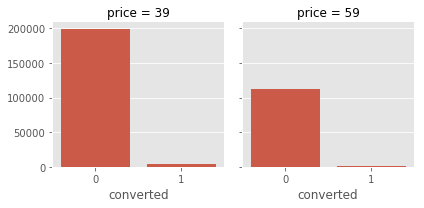

In [8]:
sns.FacetGrid(df, col='price').map(sns.countplot,'converted')

In [12]:
total_c = len(df[df.test == 0])
total_t = len(df[df.test == 1])
con_c = len(df[(df.test == 0) & (df.converted == 1)])
con_t = len(df[(df.test == 1) & (df.converted == 1)])
p_c = float(con_c)/total_c
p_t = float(con_t)/total_t

In [11]:
def abtest(total_c, total_t,con_c,con_t):
    p_c = float(con_c)/total_c
    p_t = float(con_t)/total_t
    p_pool = float(con_c + con_t)/(total_c + total_t)
    sd_pool = np.sqrt(p_pool*(1-p_pool)*(1.0/total_c+1.0/total_t))
    p_d = p_t - p_c
    z_score = p_d/sd_pool
    lower = p_d-1.96*sd_pool
    upper = p_d+1.96*sd_pool
    print "Z Score is %.4f"%z_score
    print "Confidence Interval is [%.4f,%.4f]" %(lower,upper)

In [13]:
abtest(total_c, total_t,con_c,con_t)

Z Score is -8.7828
Confidence Interval is [-0.0053,-0.0034]


In [14]:
p_c

0.019903614220108817

In [15]:
p_t

0.015542678810936857

Because the confidence interval do not contain 0, so this metric is statistically significant. In other words, in test group, the conversion rate will be decreased due to the price increase.

In [16]:
p_c - 0.0053

0.014603614220108817

If we use the worst conversion rate of test group (0.0146), then we could calculate the impact (assuming 100 users).
* for 39, we will have 100 X 0.0199 X 39 = 77.61
* for 59, we will have 100 X 0.0146 X 59 = 86.14
* So, the expected value of 59 pricing is higher than 39. I would recommand selling the software for 59.

In [17]:
import scipy.stats as ss
revenues = df.groupby(by="test").apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
df.groupby('test').apply(group_statistics)
ttest_result = ss.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)

In [20]:
# ttest_ind is a two tailed
# since our HA is test_mean > ctrl_mean, so we need to divide by 2
ttest_result.pvalue/2

7.7037493023391909e-09

In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2,f_classif
X = df.copy()
src_label_encoder = LabelEncoder()
dev_label_encoder = LabelEncoder()
os_label_encoder = LabelEncoder()

X["source"] = src_label_encoder.fit_transform(df.source)
X["device"] = dev_label_encoder.fit_transform(df.device)
X["OS"] = os_label_encoder.fit_transform(df.operative_system)

In [27]:
colnames = ["source","device","OS"]
ch2values,pvalues = chi2(X.loc[:,colnames],X["test"])
pd.DataFrame({'chi2_value':ch2values,'pvalue':pvalues},index = colnames).sort_values(by='pvalue')

,chi2_value,pvalue
OS,83.085986,7.856065e-20
device,44.366335,2.723301e-11
source,0.924742,3.362329e-01


In [29]:
def calc_ratios(s):
    d = s.value_counts(normalize=True)
    d['total'] = s.shape[0]
    return d
test_ctrl_by_os = df.groupby('operative_system')['test'].apply(calc_ratios).unstack()
test_ctrl_by_os

,0,1,total
operative_system,,,
android,0.643358,0.356642,74935.0
iOS,0.647934,0.352066,95465.0
linux,0.533736,0.466264,4135.0
mac,0.652422,0.347578,25085.0
other,0.647865,0.352135,16204.0
windows,0.629764,0.370236,100976.0


For Linux operative system, the control/test is not randomly selected. So the result may not right.

In [30]:
test_ctrl_by_device = df.groupby('device')['test'].apply(calc_ratios).unstack()
test_ctrl_by_device

,0,1,total
device,,,
mobile,0.646111,0.353889,186471.0
web,0.631064,0.368936,130329.0


Now, if we exclude all the linux users.

In [31]:
df1 = df[df['operative_system'] != 'linux']

In [34]:
revenues = df1.groupby(by="test").apply(lambda df: df.price * df.converted)
ctrl_revenues = revenues[0]
test_revenues = revenues[1]
def group_statistics(df):
    return pd.Series({'n_users': df.shape[0],
                      'convert_rate': df.converted.mean(), 
                      'mean_revenue': (df.price * df.converted).mean()})
df1.groupby('test').apply(group_statistics)
ttest_result = ss.ttest_ind(test_revenues,ctrl_revenues,equal_var=False)
ttest_result.pvalue/2

4.5128368250187665e-10

The result is still statistically significant. We can now confidently say that we should choose $59

## How to increase conversion rate

In [35]:
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [39]:
converted_by_os = df.groupby("operative_system")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

,0,1
operative_system,,
mac,0.976002,0.023998
iOS,0.977678,0.022322
windows,0.983045,0.016955
android,0.985067,0.014933
other,0.987040,0.012960
linux,0.991778,0.008222


In [40]:
converted_by_os = df.groupby("device")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

,0,1
device,,
mobile,0.981445,0.018555
web,0.981984,0.018016


In [41]:
converted_by_os = df.groupby("source")['converted'].apply(lambda s: s.value_counts(normalize=True)).unstack()
converted_by_os.sort_values(by=1,ascending=False)

,0,1
source,,
friend_referral,0.961295,0.038705
seo-bing,0.976312,0.023688
ads-google,0.978511,0.021489
ads_facebook,0.978800,0.021200
seo-google,0.982999,0.017001
seo-yahoo,0.983791,0.016209
seo_facebook,0.983966,0.016034
seo-other,0.984341,0.015659
ads-yahoo,0.985230,0.014770


### Decision Tree

### Logistic Regression

In [45]:
df_source = pd.get_dummies(df.source,prefix = 'source')
df_1 = pd.concat([df,df_source],axis = 1)

del df_1['source_ads_other']

In [46]:
df_1.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,...,source_ads-google,source_ads-yahoo,source_ads_facebook,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,...,0,0,1,0,0,0,0,0,0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,...,0,0,0,0,0,0,1,0,0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,...,0,0,0,0,0,0,0,0,0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,...,0,0,0,1,0,0,0,0,0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,...,0,0,1,0,0,0,0,0,0,0


In [47]:
df_device = pd.get_dummies(df.device,prefix = 'device')
df_2 = pd.concat([df_1,df_device],axis = 1)

del df_2['device_web']

In [48]:
df_os = pd.get_dummies(df.operative_system,prefix = 'os')
df_3 = pd.concat([df_2,df_os],axis = 1)

del df_3['os_other']

In [49]:
df_3.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,...,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_mobile,os_android,os_iOS,os_linux,os_mac,os_windows
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,...,0,0,0,0,1,0,1,0,0,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,...,1,0,0,0,1,1,0,0,0,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,...,0,0,0,0,1,1,0,0,0,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,...,0,0,0,0,1,0,1,0,0,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,...,0,0,0,0,0,0,0,0,1,0


In [53]:
df_3.country.unique()

array(['USA', nan], dtype=object)

In [54]:
del df_3['user_id']
del df_3['timestamp']
del df_3['source']
del df_3['device']
del df_3['operative_system']
del df_3['test']
del df_3['city']
del df_3['lat']
del df_3['long']
del df_3['country']

In [55]:
X = df_3.loc[:,df_3.columns != 'converted']
y = df_3.loc[:,'converted']

In [56]:
import statsmodels.api as sm
logit = sm.Logit(y, X)
result = logit.fit()
result.summary()

C:\Users\rwang\AppData\Local\Continuum\Miniconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.090121
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               316800
Model:                          Logit   Df Residuals:                   316782
Method:                           MLE   Df Model:                           17
Date:                Sun, 01 Oct 2017   Pseudo R-squ.:                 0.01486
Time:                        21:20:39   Log-Likelihood:                -28550.
converged:                       True   LL-Null:                       -28981.
                                        LLR p-value:                3.986e-172
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
price                     -0.0164      0.001    -11.917      0.000      -0.019      -0.014
source_ads-bing           -0.2989      0.076     -3.952      0.000      -0.447      -0.151
source_ads-google          0.3165      0.054      5.914      0.000       0.212       0.421
source_ads-yahoo          -0.0871      0.106     -0.825      0.409      -0.294       0.120
source_ads_facebook        0.2973      0.054      5.467      0.000       0.191       0.404
source_direct_traffic     -0.2537      0.058     -4.343      0.000      -0.368      -0.139
source_friend_referral     0.9249      0.058     15.932      0.000       0.811       1.039
source_seo-bing            0.4144      0.149      2.782      0.005       0.122       0.706
source_seo-google          0.0697      0.068      1.023      0.306      -0.064       0.203
source_seo-other          -0.0120      0.095     -0.126      0.900      -0.199       0.175
source_seo-yahoo           0.0397      0.106      0.374      0.708      -0.168       0.247
source_seo_facebook        0.0279      0.071      0.393      0.695      -0.111       0.167
device_mobile             -3.7246      0.100    -37.116      0.000      -3.921      -3.528
os_android                 0.1243      0.076      1.640      0.101      -0.024       0.273
os_iOS                     0.5268      0.073      7.225      0.000       0.384       0.670
os_linux                  -4.2050      0.188    -22.363      0.000      -4.574      -3.836
os_mac                    -3.1281      0.083    -37.528      0.000      -3.291      -2.965
os_windows                -3.4682      0.077    -45.178      0.000      -3.619      -3.318
==========================================================================================
"""

increase conversion rate:
* ads-google
* ads-facebook
* source friend referral
* source seo bing
* ios
decrease conversion rate:
* ads-bing
* direct traffic
* device mobile
* linux, mac, windows

## Experiment Duration

In [57]:
df.timestamp.max()

'2015-05-31 23:59:45'

In [58]:
df.timestamp.min()

'2015-03-02 00:04:12'

In [59]:
from scipy.stats import norm, zscore

def sample_power_probtest(p1, p2, power=0.8, sig=0.05):
    z = norm.isf([sig/2]) #two-sided t test
    zp = -1 * norm.isf([power]) 
    d = (p1-p2)
    s =2*((p1+p2) /2)*(1-((p1+p2) /2))
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

def sample_power_difftest(d, s, power=0.8, sig=0.05):
    z = norm.isf([sig/2])
    zp = -1 * norm.isf([power])
    n = s * ((zp + z)**2) / (d**2)
    return int(round(n[0]))

In [81]:
n = sample_power_probtest(0.09, 0.099, power=0.8, sig=0.05)
print n

16583


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
city                275616 non-null object
country             275616 non-null object
lat                 275616 non-null float64
long                275616 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 41.4+ MB


In [88]:
df[df['timestamp'] < '2015-03-15 00:00:00'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44925 entries, 6 to 316799
Data columns (total 12 columns):
user_id             44925 non-null int64
timestamp           44925 non-null object
source              44925 non-null object
device              44925 non-null object
operative_system    44925 non-null object
test                44925 non-null int64
price               44925 non-null int64
converted           44925 non-null int64
city                39062 non-null object
country             39062 non-null object
lat                 39062 non-null float64
long                39062 non-null float64
dtypes: float64(2), int64(4), object(6)
memory usage: 4.5+ MB


https://www.evanmiller.org/ab-testing/sample-size.html#!2;80;5;0.4;0
* Sample size: 19,784
https://www.optimizely.com/sample-size-calculator/?conversion=2&effect=20&significance=95
* Sample size: 20,000

In [91]:
# https://julienlenestour.com/maths-behind-minimum-sample-size-ab-testing/
def sample_size_power_80(variations, cr, performance):
    return float(16*(variations+1)*(1-cr))/float(cr)/performance/performance

In [93]:
sample_size_power_80(1,0.02,0.2)

39200.0

For safety, I choose 39200 sample size as the minium sample size to get statistical significance.